# CAP394 - Introdução à Data Science

Letícia Meirelles

Professores: 

    Gilberto Queiroz
    Rafael Santos
    
## Projeto Final

Existe grande interesse na preservação do Cerrado principalmente devido à sua alta biodiversidade (Myers et al 2000) e potencial de recursos naturais (Nóbrega et al. 2017). Apesar disso, o bioma deverá sofrer com pressões devido à mudanças no clima e em seu uso e cobertura, como a produção de soja e milho, e pastagens (Miranda et al. 2014). Assim, a capacidade de simular a dinâmica do Cerrado pode contribuir em tomadas de decisões sobre sua preservação. Isto inclui o desenvolvimento de métodos para simular a ocorrência do fogo, o que têm uma forte influência na dinâmica da vegetação desta região (Arruda et al. 2018).

Esse trabalho aborda a exploração de técnicas de ciências de dados com o objeivo de simular a ocorrência do fogo a partir de variáveis ambientais calculadas pelo Integrated Land Surface Model (INLAND, baseado em Foley et al. 1998). O INLAND oferece a capacidade de simular a dinâmica do Cerrado sob diferentes condições climáticas e de uso na terra, e explorar mecanismos de interação entre a atmosfera e a superfície da região.

Objetivos se concentram em validar técnicas de modelagem disponíveis a partir das técnicas de ciências de dados como suporte de cálculo da ocorrência natural de fogo a partir de saídas do INLAND em simulações da dinâmica de vegetação, pelas informações que o modelo provém sobre biomassa vegetal e umidade do solo. Além destas informações, são também utilizados dados meteorológicos de precipitação e velocidade do vento do INLAND e detecções de fogo pelo sensoriamento remoto com o Moderate Resolution Imaging Spectroradiometer (MODIS).

## Dataset
Os dados são constituidos a partir dos resultados do modelo INLAND e dados de focos de queimadas do produto MODIS MCD14ML (University of Maryland, EUA, http://modis-fire.umd.edu). O INLAND é desenvolvido no CCST/INPE com base em Foley et al. (1996), e simula as características dominantes da superfície vegetada continental, com resolução espacial de 50km, e em escala temporal de dias-anos. O modelo reproduz processos superficiais que representam os efeitos do clima na superfície (como crescimento ou mortalidade da vegetação), e da superfície no clima (como evapotranspiração e reflexão da energia solar), e permite considerar cenários de desmatamento e agricultura.

Para obtenção dos resultados com o INLAND, realizou-se uma simulação no domínio de território do Brasil para um período total de 110 anos. A fim de se evitar efeitos de condições iniciais, a extração de valores simulados se concentrou nos últimos 10 anos apenas. A configuração desta simulação contempla a dinâmica de vegetação, concentração de CO2 estática, e dinâmica de uso da terra desativada. Os dados de entrada sobre condições atmosféricas correspondem a uma climatologia de trinta anos (1961 a 1990) gerada a partir de dados do CRU (Climate Research Unit, Global Climate Dataset).

Depois da execução da simulação do INLAND, foi realizado o recorte para a região da Serra do Espinhaço-MG, para longitude -44.75 até -43.25(3 pontos de grade) e latitude -18.25 até -17.25 (4 pontos de grade), escolhido como uma região representativa das condições do Cerrado. A sub-região de estudo totaliza uma área de 12 pontos de grade, onde foram extraídas saídas com frequência mensal. O número total de amostras é equivalente à $10*12*12=1440$. Cada amostra as seguintes variáveis: umidade do solo, biomassa total acima do solo, velocidade do vento na superfície, temperatura próxima à superfície, e precipitação média.

Após o recorte da região, do período e variáveis das saídas do INLAND foi necessário gerar a matriz de informações produzidas pelo inland e as informações de ocorrência correnpondênte para a amostra do MODIS.

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')

In [48]:
df = pd.read_csv('fire.txt',sep=' ', error_bad_lines=False)
df.head()
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
del df2['cbiol_3'],df2['cbiol_4'],df2['cbiol_5'],df2['cbiol_6'],df2['cbiol_7']
del df2['cbiol_8'],df2['cbiow_11'],df2['cbiow_12'],df2['cbiow_3'],df2['cbiow_4'],df2['cbiow_5'],df2['cbiow_6'],df2['cbiow_7'],df2['cbiow_8']
del df2['frac_3'],df2['frac_4'],df2['frac_5'],df2['frac_6'],df2['frac_7'],df2['frac_8']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=" ")
print('\n')
df = df2
df.info()

List of dropped columns: cbiol_3 cbiol_4 cbiol_5 cbiol_6 cbiol_7 cbiol_8 cbiow_11 cbiow_12 cbiow_3 cbiow_4 cbiow_5 cbiow_6 cbiow_7 cbiow_8 frac_3 frac_4 frac_5 frac_6 frac_7 frac_8 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 26 columns):
data        1440 non-null object
mes         1440 non-null int64
lat         1440 non-null float64
lon         1440 non-null float64
cbiol_10    1440 non-null float64
cbiol_11    1440 non-null float64
cbiol_12    1440 non-null float64
cbiol_1     1440 non-null float64
cbiol_2     1440 non-null float64
cbiol_9     1440 non-null float64
cbiow_10    1440 non-null float64
cbiow_1     1440 non-null float64
cbiow_2     1440 non-null float64
cbiow_9     1440 non-null float64
frac_10     1440 non-null float64
frac_11     1440 non-null float64
frac_12     1440 non-null float64
frac_1      1440 non-null float64
frac_2      1440 non-null float64
frac_9      1440 non-null float64
rain        1440 non-null float64

| variável |descrição | unidade |
|:-----|:-----:|-----:|
| rain | average precipitation | mm/day |
| ua | Near surface wind speed | m s-1 |
| cbiow |  biomass carbon upper | kg/m^2 |
| cbiol |  biomass carbon lower | kg/m^2 |
| frac | fractional cover per pft | fraction |
| totalit | total above ground litter carbon | kg/m^2|
| wsoi | fraction of soil pore space containing liquid water | fraction |

Inland uses a small number of plant functional types(PFTs):

| id | PFT |  classes de vegetação |
|---|:---:|---:|
|  1| tropical broadleaf evergreen tree | tropical evergreen forest / woodland|
|  2| tropical broadleaf drought-deciduous trees |tropical deciduous forest / woodland|
|  3| warm-temperate broadleaf evergreen tree | temperate evergreen broadleaf forest / woodland|
|  4|temperate conifer evergreen tree | temperate evergreen conifer forest / woodland | 
|  5| temperate broadleaf cold-deciduous tree | temperate deciduous forest / woodland |
|  6| boreal conifer evergreen tree | boreal evergreen forest / woodland |
|  7| boreal broadleaf cold-deciduous tree | boreal deciduous forest / woodland|
|  8|boreal conifer cold-deciduous tree | mixed forest / woodland | 
|  9| evergreen shrub | savanna |
| 10| deciduous shrub | grassland / steppe |
| 11| warm (c4) grass | dense shrubland |
| 12| cool (c3) grass | open shrubland |
| 13| soybeans | tundra |
| 14| maize | desert |
| 15| spring and winter wheat |  spring and winter wheat |
| 16| sugarcane |  polar desert / rock / ice |

In [18]:
df.sample(frac=0.01, replace=True, random_state=1)

,data,mes,lat,lon,cbiol_10,cbiol_11,cbiol_12,cbiol_1,cbiol_2,cbiol_9,...,frac_12,frac_1,frac_2,frac_9,rain,totalit,totbio,ua,wsoi,modis
1061,2107-05-01,5,-17.75,-44.25,0.000459,0.000761,0.000589,0.003435,0.202263,0.000841,...,0.364472,0.016697,0.983304,0.325621,0.700001,0.567599,7.805720,2.93182,0.499480,3.55556
235,2101-08-01,8,-17.75,-43.25,0.000467,0.000574,0.000668,0.080344,0.063455,0.000900,...,0.279867,0.581739,0.418262,0.235495,0.400000,0.481399,6.170990,2.96685,0.489190,10.64710
1096,2107-08-01,8,-17.75,-44.75,0.000520,0.119152,0.000634,0.000400,0.000400,0.000876,...,0.003299,0.909092,0.090909,0.028484,0.300000,0.011024,0.130556,2.88352,0.573957,14.17650
905,2106-04-01,4,-17.75,-44.25,0.000455,0.000710,0.000610,0.003696,0.210711,0.000852,...,0.447020,0.017236,0.982764,0.390698,2.000000,0.563529,7.821030,2.88812,0.583700,2.50000
715,2104-12-01,12,-17.75,-43.25,0.000573,0.000666,0.000827,0.094275,0.076105,0.001018,...,0.290638,0.553324,0.446677,0.223635,7.500010,0.474468,6.210350,3.09158,0.861505,2.76923
847,2105-11-01,11,-17.75,-43.25,0.000460,0.000572,0.000663,0.097056,0.077879,0.000909,...,0.278876,0.554811,0.445190,0.238881,7.100010,0.477374,6.236400,2.97505,0.762568,9.23077
960,2106-09-01,9,-17.25,-44.75,0.000627,0.252584,0.000746,0.000400,0.000400,0.001017,...,0.001337,0.908991,0.091010,0.003970,0.900001,0.019869,0.265100,2.88776,0.528378,27.82350
144,2101-01-01,1,-17.25,-44.75,0.000548,0.192465,0.000670,0.000400,0.000400,0.000943,...,0.003447,0.500000,0.500001,0.003032,7.800010,0.025905,0.206807,2.95220,0.668237,2.00000
129,2100-11-01,11,-18.25,-44.25,0.000456,0.000734,0.000582,0.007656,0.189256,0.000824,...,0.242438,0.038882,0.961119,0.214558,7.300010,0.544409,7.876570,2.89412,0.653326,5.87500
749,2105-03-01,3,-17.75,-44.25,0.000416,0.000624,0.000530,0.003230,0.184941,0.000812,...,0.243013,0.017164,0.982837,0.232619,4.600000,0.571535,7.754650,2.93050,0.683689,2.33333


In [49]:
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
del df2['data'],df2['lat'],df2['lon'],df2['cbiol_1'],df2['cbiol_2'], df2['cbiol_9']
del df2['cbiol_10'],df2['cbiol_11'], df2['cbiol_12']
del df2['cbiow_1'],df2['cbiow_2'], df2['cbiow_9']
del df2['cbiow_10']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=" ")
print('\n')
df = df2

List of dropped columns: data lat lon cbiol_10 cbiol_11 cbiol_12 cbiol_1 cbiol_2 cbiol_9 cbiow_10 cbiow_1 cbiow_2 cbiow_9 



In [50]:
def plotBox(x,y,title):
    plt.figure(figsize = (10, 6))
    ax = sns.boxplot(df[x], df[y])
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.title(title)
    plt.xticks(rotation=45)

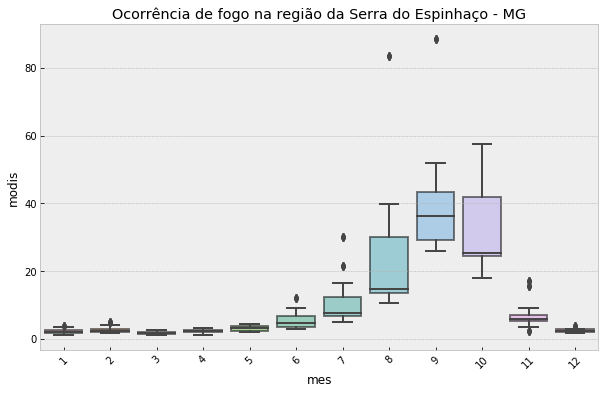

In [51]:
plotBox('mes','modis','Ocorrência de fogo na região da Serra do Espinhaço - MG')

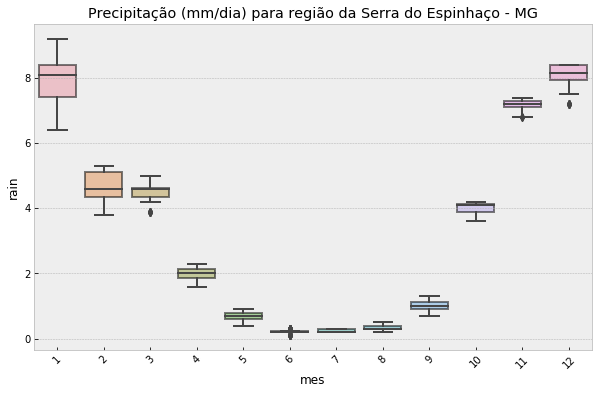

In [52]:
plotBox('mes','rain','Precipitação (mm/dia) para região da Serra do Espinhaço - MG')

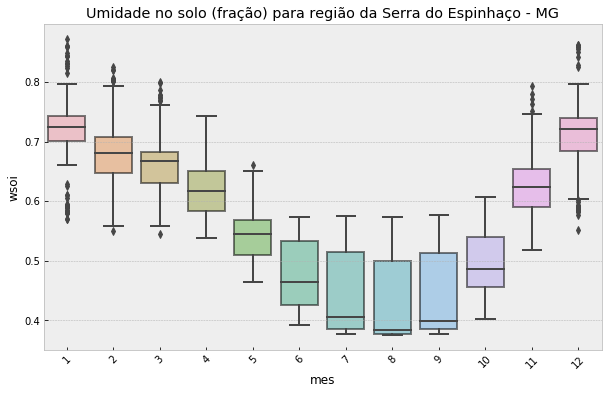

In [53]:
plotBox('mes','wsoi','Umidade no solo (fração) para região da Serra do Espinhaço - MG')

A precipitação de chuva irá influênciar no umidade do solo, quanto mais seco for o ambiente maior será a periculosidade do material combustível florestal, as figuras XX apresentam os valores e chuva e umidade no solo para a região da serra do espinhaço.

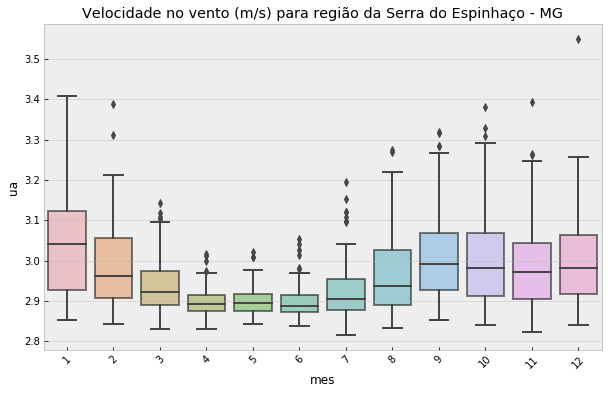

In [54]:
plotBox('mes','ua','Velocidade no vento (m/s) para região da Serra do Espinhaço - MG')

In [55]:
df.describe()
#plt.figure(figsize=(9, 8))
#sns.distplot(df['rain'], color='g', bins=100, hist_kws={'alpha': 0.4});

,mes,frac_10,frac_11,frac_12,frac_1,frac_2,frac_9,rain,totalit,totbio,ua,wsoi,modis
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,6.500000,0.133564,0.442031,0.185538,0.296571,0.703430,0.238868,3.403474,0.423345,5.741599,2.963714,0.570185,11.334434
std,3.453252,0.100155,0.354208,0.132706,0.332018,0.332018,0.211361,2.966609,0.249916,3.255613,0.102747,0.122625,15.492272
min,1.000000,0.000370,0.029655,0.000348,0.009306,0.073542,0.002343,0.100000,0.009076,0.123692,2.814760,0.374807,1.000000
25%,3.750000,0.015459,0.096208,0.020029,0.017260,0.465581,0.071598,0.500000,0.282782,4.131075,2.891142,0.473784,2.321425
50%,6.500000,0.136514,0.329688,0.215826,0.091954,0.908047,0.217110,2.950000,0.441241,6.125445,2.927785,0.574839,3.735045
75%,9.250000,0.230928,0.874691,0.279867,0.534420,0.982741,0.326020,5.575007,0.568789,7.826058,3.013607,0.669739,14.278200
max,12.000000,0.322587,0.996445,0.476920,0.926459,0.990695,0.769231,9.200010,0.886736,10.793600,3.549270,0.872348,88.529400


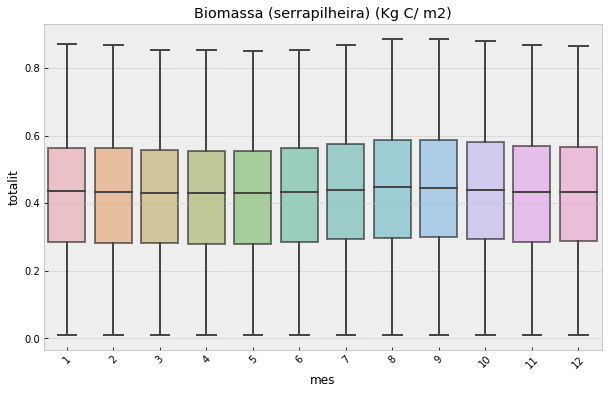

In [56]:
plotBox('mes','totalit','Biomassa (serrapilheira) (Kg C/ m2)')

O mateiral combustivel florestal pode ser definido como qualquer material orgânico vivo ou morto, no solo e acima dele, capaz de entrar em ignição e queimar, entretanto a matéria verde(madeira e folhas de vegetação viva) possui uma difícil ignição pois possuem alto teor de umidade. Deste modo, para modelagem da deve ser considarada apenas as informações de biomassa de serrapilheira, figura XX.

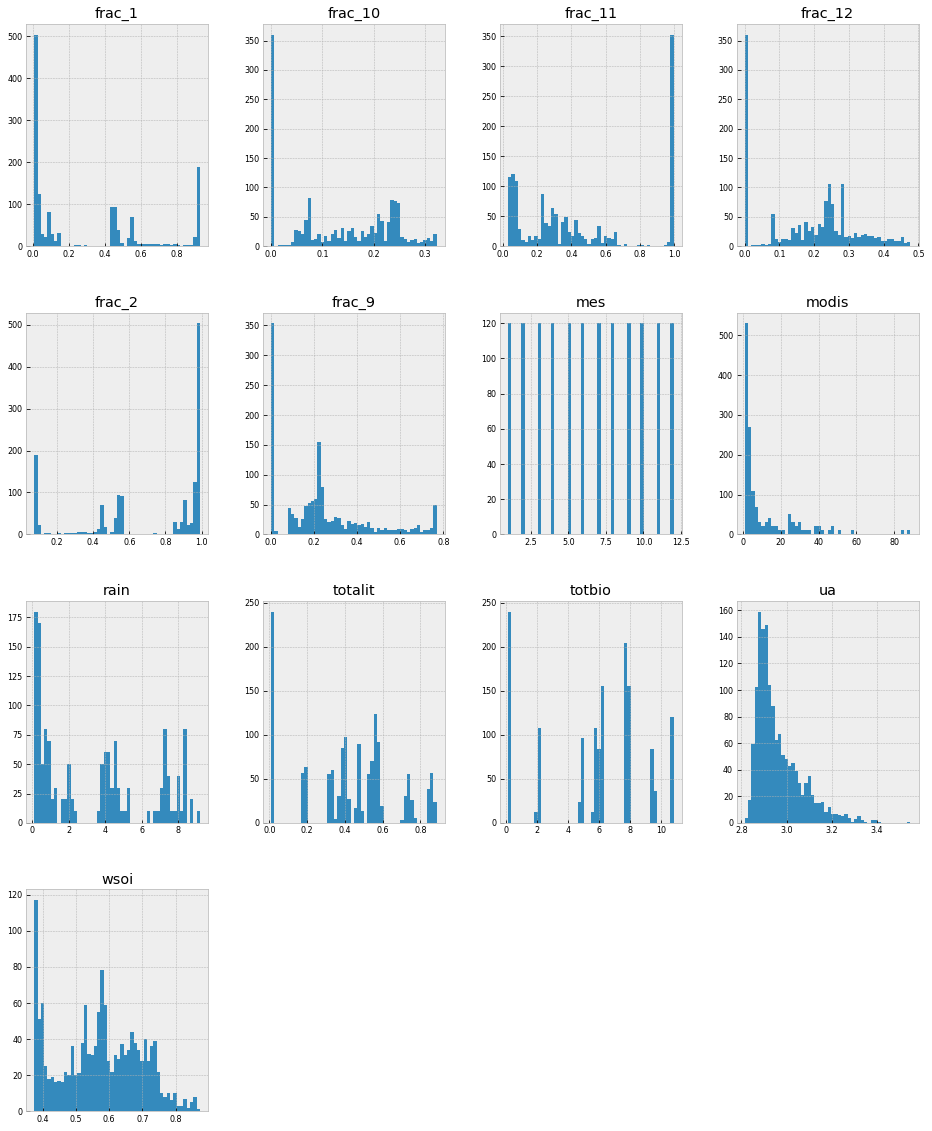

In [57]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations

In [64]:
df_num_corr = df_num.corr()['modis'][:-1] # -1 because the latest row is SalePrice
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Fire:\n{}".format(len(golden_features_list), golden_features_list))

There is 1 strongly correlated values with Fire:
wsoi   -0.55271
Name: modis, dtype: float64


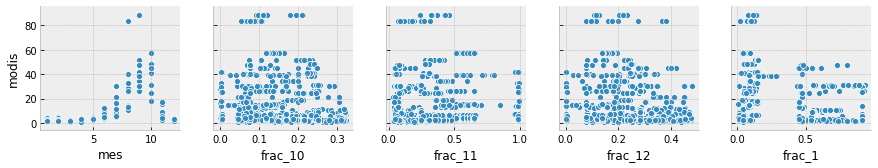

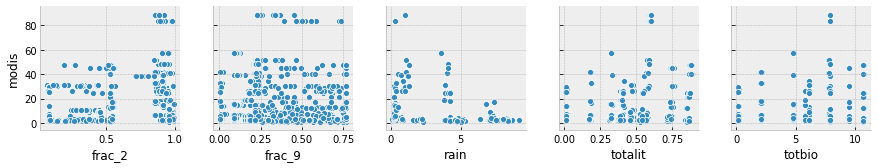

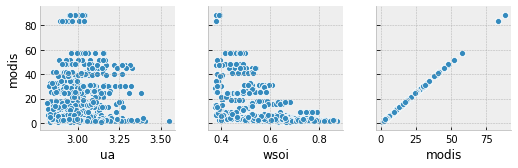

In [65]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['modis'])

In [66]:
import operator

individual_features_df = []
for i in range(0, len(df_num.columns) - 1): # -1 because the last column is modis
    tmpDf = df_num[[df_num.columns[i], 'modis']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['modis'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

           wsoi: -0.5527103847314997
           rain: -0.29848801207417736
        frac_10: -0.07941719635470101
        frac_12: -0.07782453074149846
        frac_11: -0.04209805919420226
         frac_1: -0.004794616854858815
         frac_2: 0.0047945845106863155
         totbio: 0.1065328937468161
        totalit: 0.13119571006692304
         frac_9: 0.15704536074668848
             ua: 0.17768086041478096
            mes: 0.40307356825423785


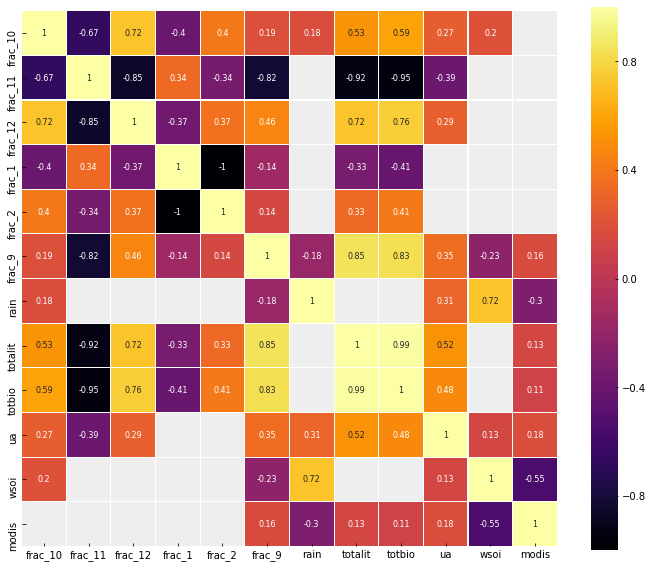

In [72]:
corr = df_num.drop('mes', axis=1).corr() # We already examined fire correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], 
            cmap='inferno', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

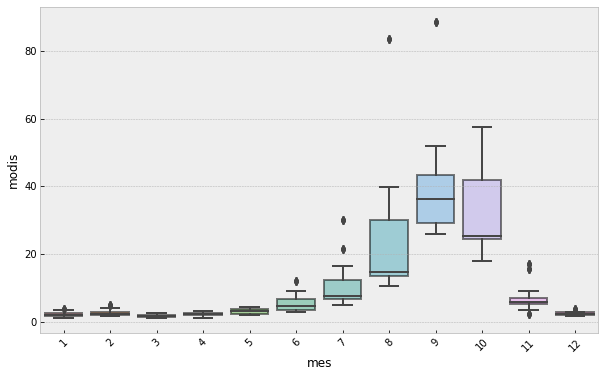

In [37]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(df['mes'], df['modis'])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

Preciptação e umidade no solo (que possuem correlação inversa com a o ocorrência de fogo), temperatura e velocidade de vento (onde o crescimento de ocorrencia de fogo coincidem com o aumento de valores de temperatura e velocidade de vento durante a seca), e quantidade de biomassa de serrapilheira.

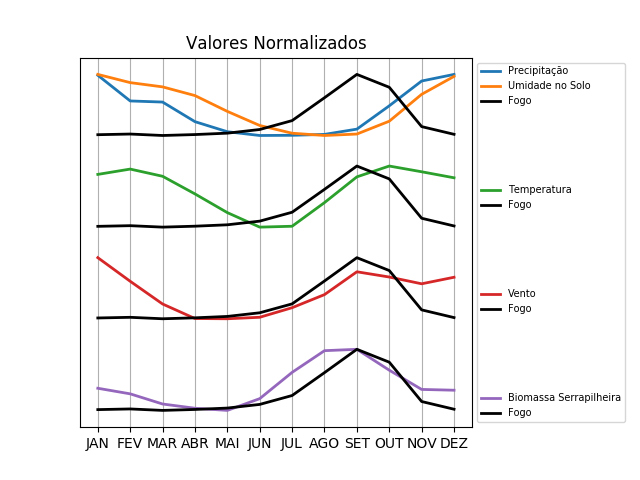

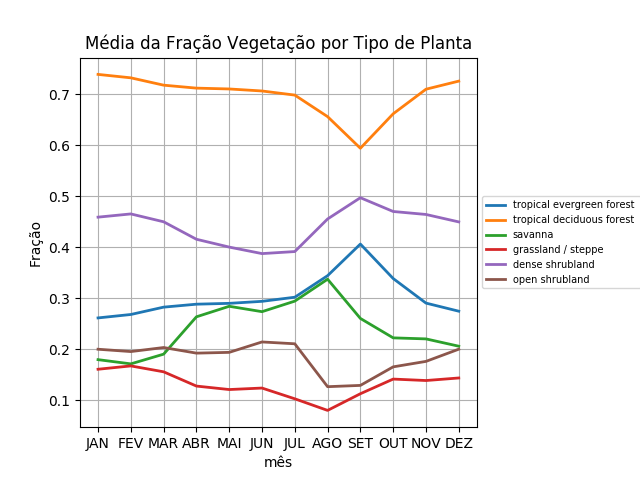

Os picos de ocorrência de fogo coincidem com os maior índices de fração maior concentração de fração de vegetação do tipo floresta tropical e gramíneas es- parsas, e correlação inversa entre pastagem/estepes, e floresta topical decídua.

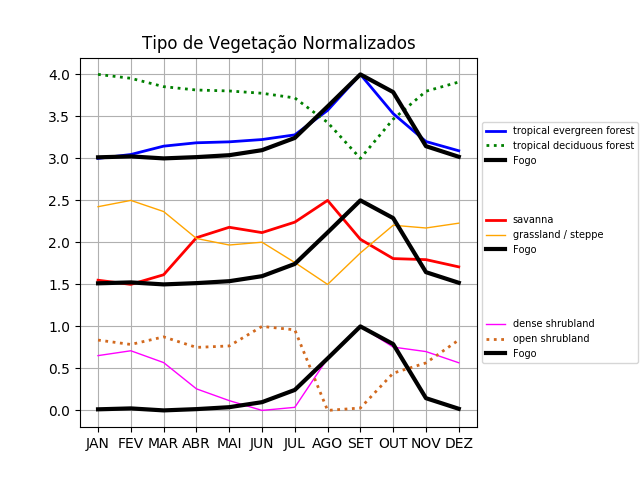

## Referências

ARRUDA, Filipe Viegas de et al. Trends and gaps of the scientific literature about the effects of fire on Brazilian Cerrado. Biota Neotropica, v. 18, n. 1, 2018.

FOLEY, Jonathan A. et al. An integrated biosphere model of land surface processes, terrestrial carbon balance, and vegetation dynamics. Global biogeochemical cycles, v. 10, n. 4, p. 603-628, 1996.

DE MIRANDA, Sabrina do Couto et al. Regional variations in biomass distribution in Brazilian savanna woodland. Biotropica, v. 46, n. 2, p. 125-138, 2014.

MYERS, Norman et al. Biodiversity hotspots for conservation priorities. Nature, v. 403, n. 6772, p. 853, 2000.

NÓBREGA, Rodolfo LB et al. Effects of conversion of native cerrado vegetation to pasture on soil hydro-physical properties, evapotranspiration and streamflow on the Amazonian agricultural frontier. PloS one, v. 12, n. 6, p. e0179414, 2017.